# ARP: EfficientNetB0 transfer learning model for chest X-ray binary classification on COVID-19 Radiography Database

#### Datasets:
* Dataset for training, validating, testing: COVID-19 Radiography Database (Qatar University & University of Dhaka).
* External dataset for testing: subset of PadChest dataset.

#### Model:
* Transfer learning with fine-tuning;
* Base model: EfficientNetB0; weights: ImageNet.
* Binary classification: class 0: "abnormal" (X-ray images with pneumonia: viral pneumonia, infiltration, COVID-19), Class 1: normal (no radiographic signs of pneumonia)

#### Study design:
1. Baseline model (w/o regularisation) + hyperparameters search
2. Models with regularisation methods:
- Batch normalisation model (Baseline model with batch normalisation)
- L2 regularisation model (Baseline model with L2 regularisation + grid search for tuning the L2 penalty)
- Dropout model (Baseline model with dropout layers + manual random search for best dropout rate).
- Model with data augmentation (Baseline model and data augmentation + manual search for better augmentation parameters)
- Combined model with all regularisation techniques
3. Evaluation on test subset of the dataset
4. Evaluation on external dataset

## Import Libraries

In [1]:
# Core libraries
import os
import random
import numpy as np
import pandas as pd
import collections

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.utils import resample, shuffle
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_recall_curve,
)

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# from tensorflow_addons.optimizers import AdamW # don't work on Kaggle
from tensorflow.keras.models import load_model

# Pre-trained models
from tensorflow.keras.applications import EfficientNetB0

# Visualisation
import matplotlib.pyplot as plt
from PIL import Image

Fix seed for reproducibility

In [2]:
SEED_VALUE = 42
random.seed(SEED_VALUE)  # 1. Set Python's built-in random seed
np.random.seed(SEED_VALUE)  # 2. Set NumPy's random seed
tf.random.set_seed(SEED_VALUE)  # 3. Set TensorFlow's random seed


## Import Data

In [3]:
# Set paths
base_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset"

data_folders = {
    "abnormal": [
        os.path.join(base_path, "Lung_Opacity/images"),
        os.path.join(base_path, "COVID/images"),
        os.path.join(base_path, "Viral Pneumonia/images"),
    ],
    "normal": [os.path.join(base_path, "Normal/images")],
}

# Build image paths and labels
image_paths = []
labels = []

for label, folders in data_folders.items():
    for folder in folders:
        if os.path.exists(folder):
            files = [
                os.path.join(folder, f)
                for f in os.listdir(folder)
                if f.endswith(".png")
            ]
            image_paths.extend(files)
            labels.extend([label] * len(files))

# Create DataFrame
df = pd.DataFrame({"path": image_paths, "label": labels})

## EDA and Data Preprocessing

In [4]:
df.shape

(21165, 2)

In [5]:
df['label'].value_counts()

label
abnormal    10973
normal      10192
Name: count, dtype: int64

In [6]:
# Split the dataset
train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df["label"], random_state=SEED_VALUE
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=SEED_VALUE
)

## Create Image Data Generators 

In [7]:
def print_class_distribution(data_generator):
    """
    Prints the number of samples for each class in a data generator.
    """
    # Count occurrences of each class
    class_counts = collections.Counter(data_generator.classes)

    # Create a mapping from class index to class name
    index_to_class = {v: k for k, v in data_generator.class_indices.items()}

    # Print class names and their sample counts
    for class_label, count in class_counts.items():
        class_name = index_to_class[class_label]
        print(f"Class '{class_name}' ({class_label}): {count} samples")

In [8]:
def show_sample_images(data_generator, num_images=9):
    """
    Displays a batch of sample images from the generator.
    """
    # Get a batch of images and labels
    images, labels = next(data_generator)

    # Ensure we don't try to display more images than exist in the batch
    num_images = min(num_images, images.shape[0])

    # Print batch shape
    print("Batch shape:", images.shape)

    # Plot the images
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype('uint8'))
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [9]:
data_gen = ImageDataGenerator()

Define batch size and image size:

In [10]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

In [11]:
train_generator = data_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=SEED_VALUE
)

Found 14815 validated image filenames belonging to 2 classes.


In [12]:
print_class_distribution(train_generator)

Class 'normal' (1): 7134 samples
Class 'abnormal' (0): 7681 samples


Batch shape: (32, 224, 224, 3)


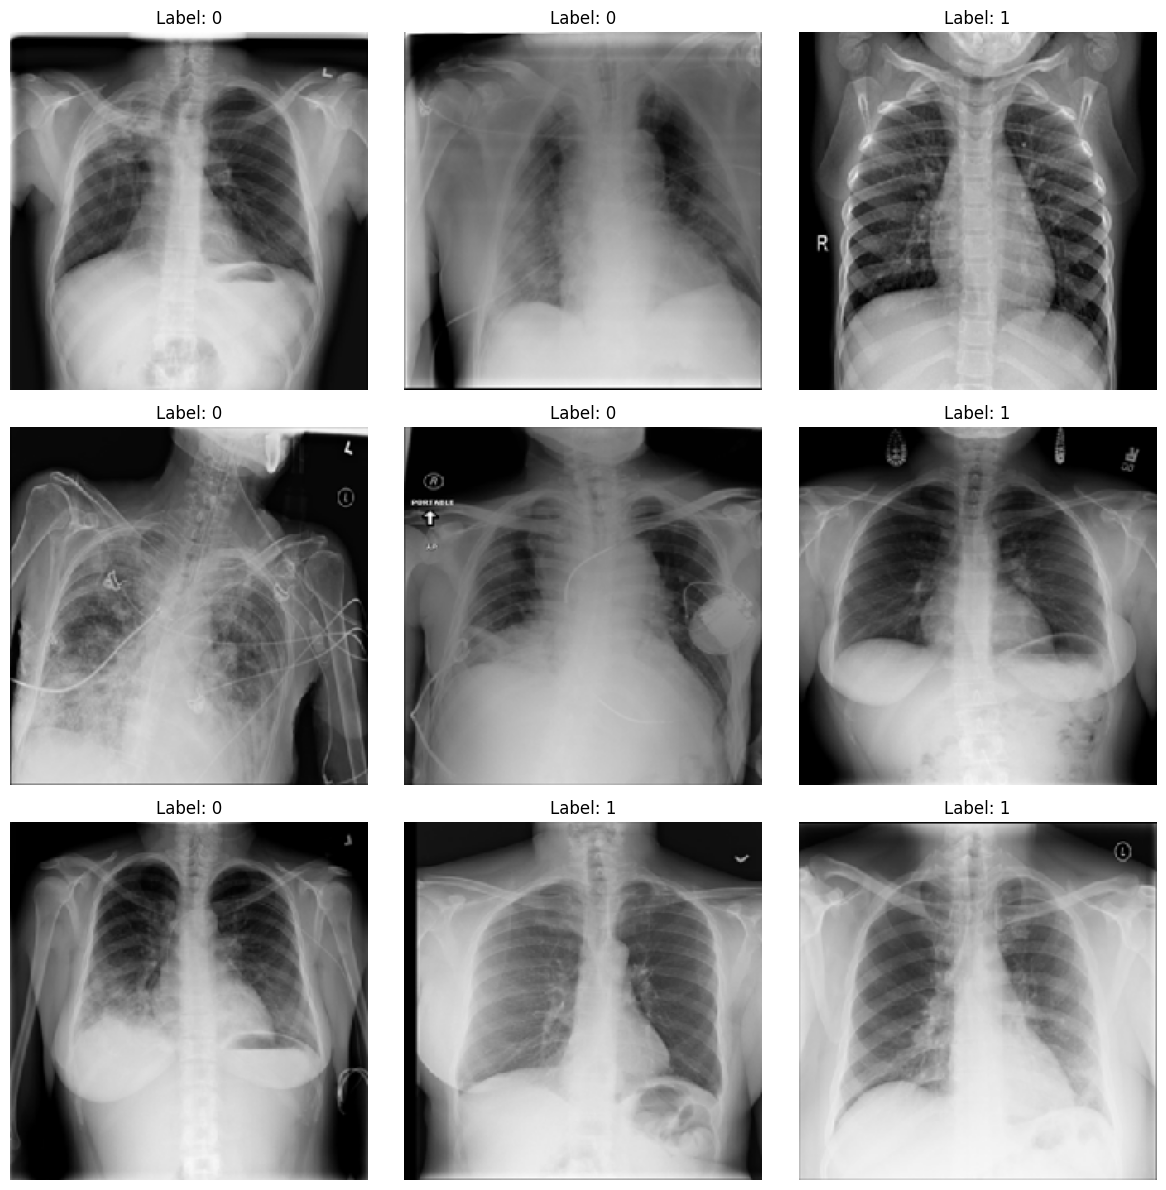

In [13]:
show_sample_images(train_generator)

In [14]:
val_generator = data_gen.flow_from_dataframe(
    dataframe=val_df,
    x_col="path",
    y_col="label",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False,    # False for threshold tuning
    seed=SEED_VALUE
)

Found 3175 validated image filenames belonging to 2 classes.


In [15]:
print_class_distribution(val_generator)

Class 'abnormal' (0): 1646 samples
Class 'normal' (1): 1529 samples


Batch shape: (32, 224, 224, 3)


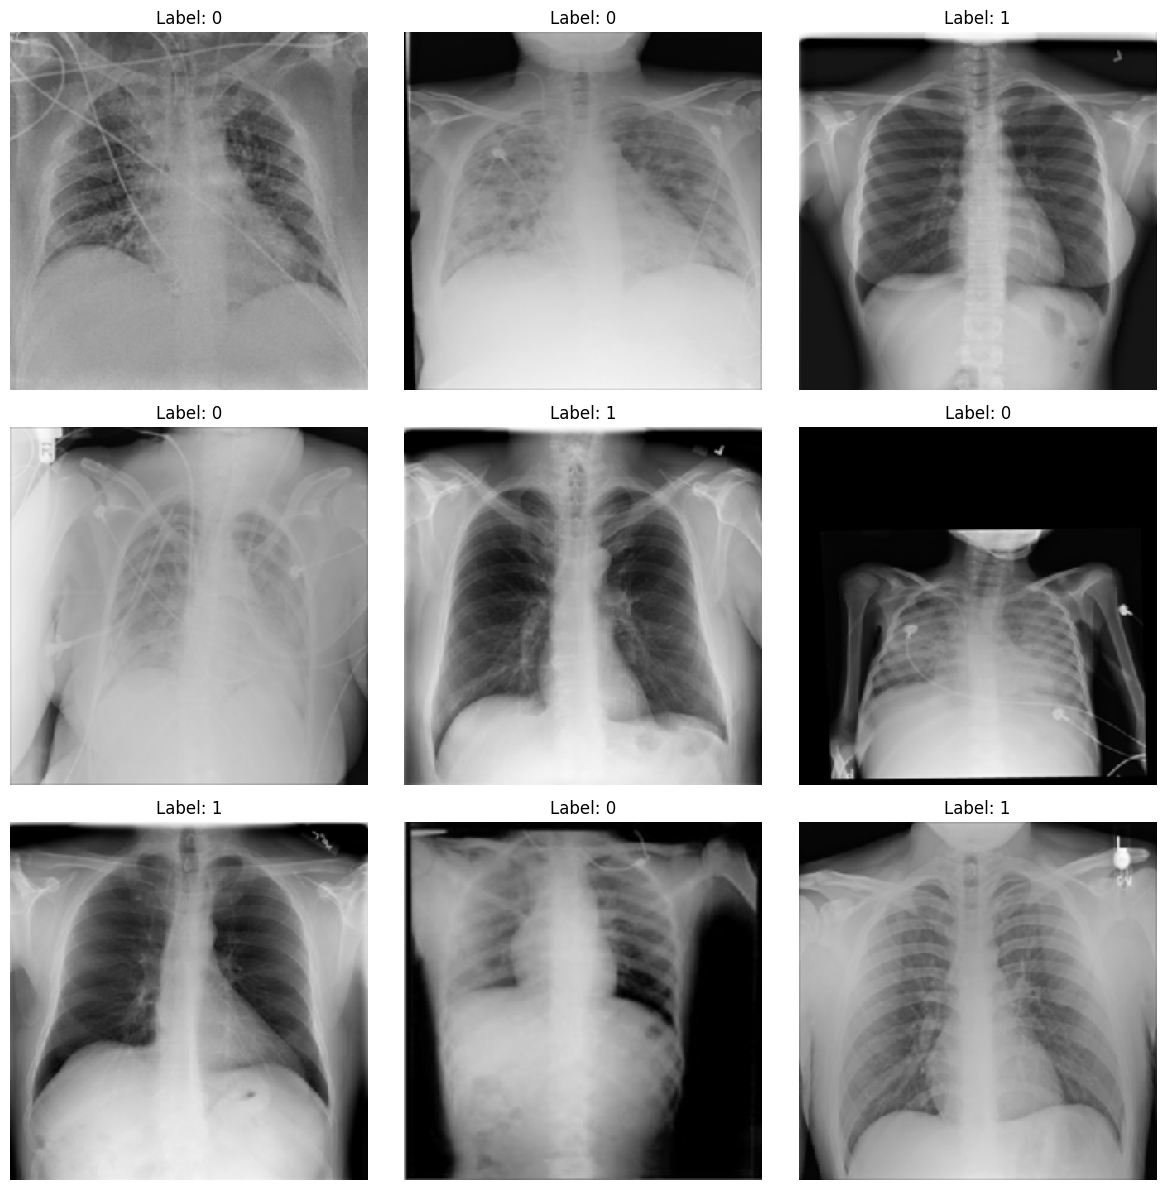

In [16]:
show_sample_images(val_generator)

In [17]:
test_generator = data_gen.flow_from_dataframe(
   dataframe=test_df,
   x_col="path",
   y_col="label",
   target_size=IMAGE_SIZE,
   batch_size=BATCH_SIZE,
   class_mode="binary",
   shuffle=False, # Do not shuffle test data to keep evaluation consistent
   seed=SEED_VALUE 
)

Found 3175 validated image filenames belonging to 2 classes.


In [18]:
print_class_distribution(test_generator)

Class 'normal' (1): 1529 samples
Class 'abnormal' (0): 1646 samples


Batch shape: (32, 224, 224, 3)


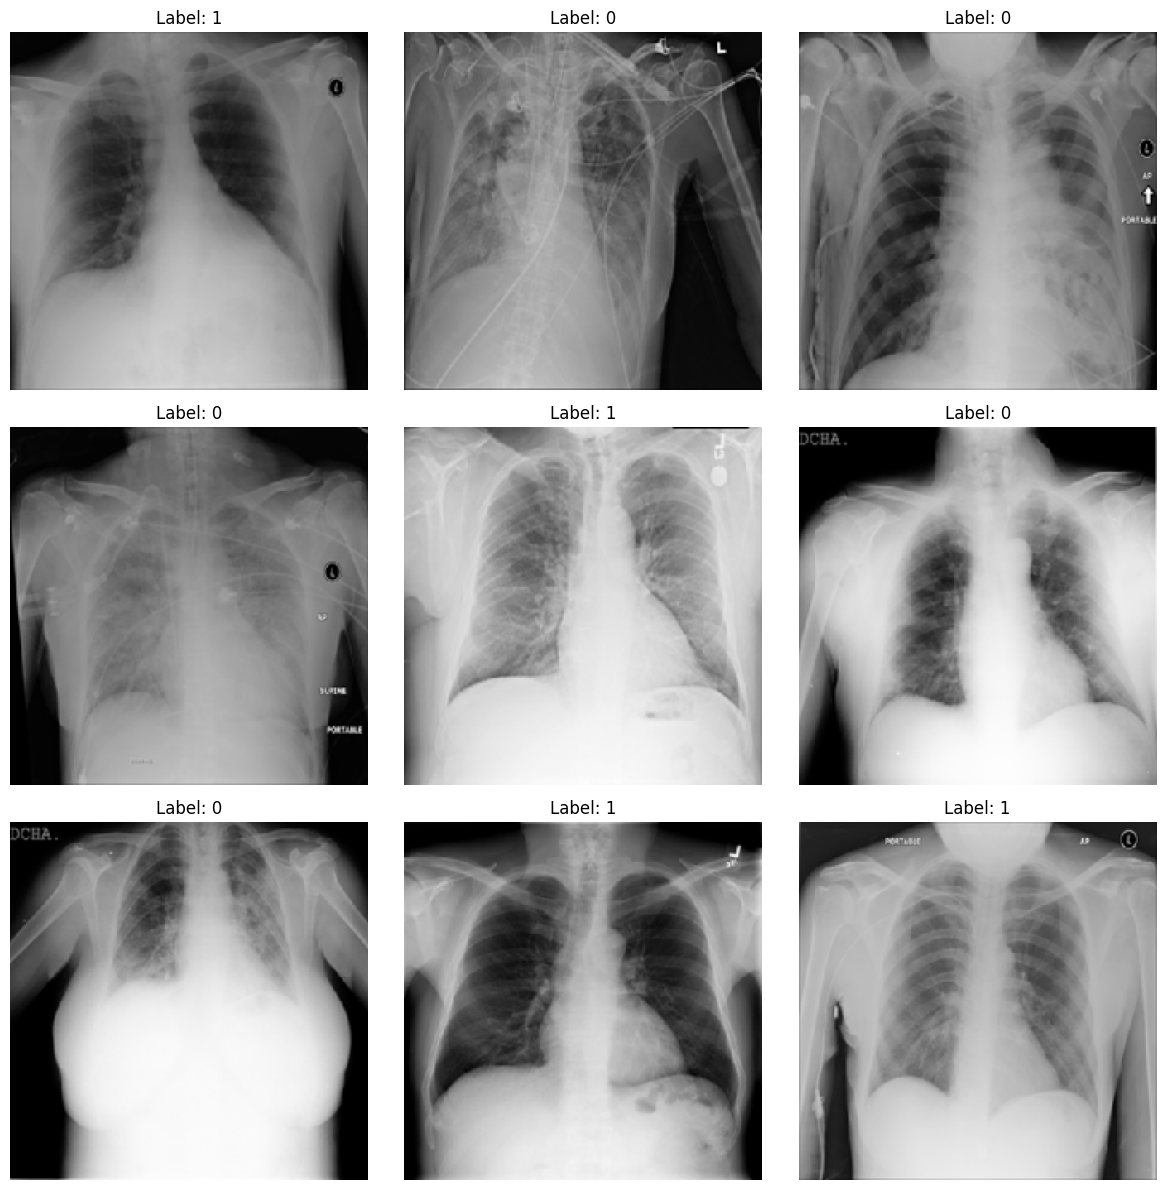

In [19]:
show_sample_images(test_generator)

## Create CNN Models

In [20]:
def plot_training_history(history):
    # Extract loss and accuracy
    train_loss = history.history['loss']
    val_loss = history.history.get('val_loss', None)  # Use .get() to avoid errors if missing
    train_acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy', None)

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Plot loss
    ax[0].plot(train_loss, label='Training Loss', color='blue')
    if val_loss:
        ax[0].plot(val_loss, label='Validation Loss', color='orange')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss Curve')
    ax[0].legend()
    ax[0].grid(True)
    #ax[0].set_xlim()
    ax[0].set_ylim(0, 1.5)

    # Plot accuracy
    ax[1].plot(train_acc, label='Training Accuracy', color='blue')
    if val_acc:
        ax[1].plot(val_acc, label='Validation Accuracy', color='orange')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy Curve')
    ax[1].legend()
    ax[1].grid(True)
    #ax[1].set_xlim()
    ax[1].set_ylim(0.5, 1)

    plt.show()

### Baseline model

Model 3: EfficientNetB0 pretrained model (El Houby, 2024)

In [65]:
def create_baseline_model_3():
    
    # Load EfficientNetB0 with pre-trained ImageNet weights
    base_model = EfficientNetB0(
        include_top=False, weights="imagenet", input_shape=(224, 224, 3)
    )
    base_model.trainable = True # True - fine tuning, False - feature extractor (showed poor performance)
    
    # Build the classification model    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),       # Reduce 4D to 2D
        layers.Dense(128, activation='relu'),  # Number and size of dense layers are results of hyperparameter search
        layers.Dense(1, activation='sigmoid')  # Binary output
    ])
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.00005),  # LR is a result of hyperparameter search
        loss='binary_crossentropy',             # Binary output
        metrics=['accuracy']                    # Accuracy the most common metric for medical images
    )                                
    
    return model

In [66]:
baseline_model = create_baseline_model_3()
baseline_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 4,171,645 (15.91 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [67]:
history_baseline = baseline_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
)

Epoch 1/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 178s 214ms/step - accuracy: 0.8357 - loss: 0.3857 - val_accuracy: 0.9046 - val_loss: 0.2555
Epoch 2/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 67s 142ms/step - accuracy: 0.9397 - loss: 0.1554 - val_accuracy: 0.9361 - val_loss: 0.1641
Epoch 3/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 65s 138ms/step - accuracy: 0.9540 - loss: 0.1215 - val_accuracy: 0.9386 - val_loss: 0.1632
Epoch 4/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 62s 133ms/step - accuracy: 0.9671 - loss: 0.0905 - val_accuracy: 0.9420 - val_loss: 0.1643
Epoch 5/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 61s 130ms/step - accuracy: 0.9774 - loss: 0.0616 - val_accuracy: 0.9175 - val_loss: 0.2293
Epoch 6/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 62s 131ms/step - accuracy: 0.9820 - loss: 0.0503 - val_accuracy: 0.9449 - val_loss: 0.1770
Epoch 7/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 61s 131ms/step - accuracy: 0.9877 - loss: 0.0374 - val_accuracy: 0.9370 - val_loss: 0.1901
Epoch 8/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 61s 130ms/step - accuracy: 0.9883 - loss: 

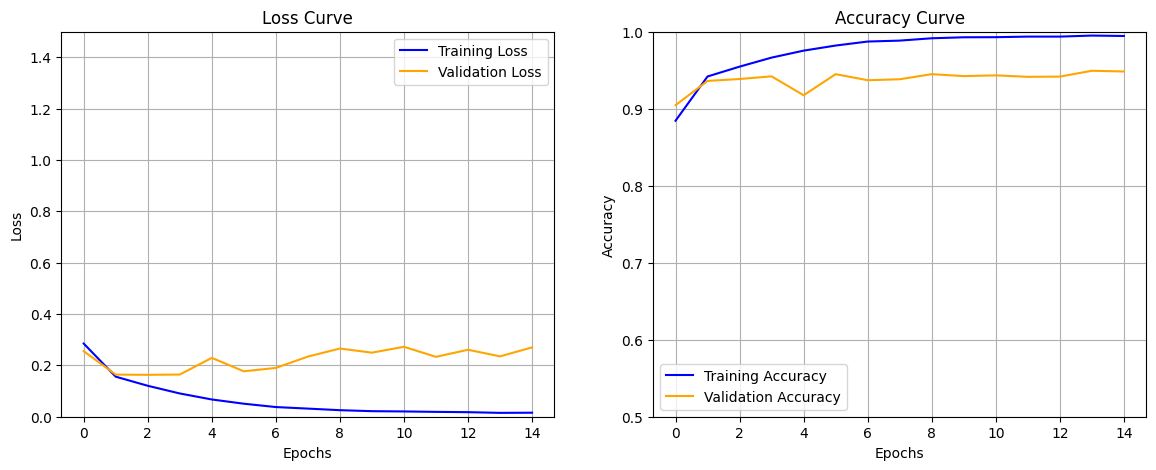

In [68]:
plot_training_history(history_baseline)

In [69]:
baseline_df = pd.DataFrame(history_baseline.history)
baseline_df.to_csv("baseline_df.csv", index=False)

In [70]:
baseline_model.save('baseline_model_final.keras')

In [71]:
baseline_model.save_weights('baseline_model_final.weights.h5')

### Batch Normalisation

In [83]:
def create_bn_model_3():
    base_model = EfficientNetB0(
        include_top=False, weights="imagenet", input_shape=(224, 224, 3)
    )
    base_model.trainable = True
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),       
        #layers.Dropout(0.5),
        #layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),           # BN layer
        #layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.00005), 
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    return model

In [84]:
bn_model = create_bn_model_3()
bn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,214,180 (16.08 MB)

 Trainable params: 4,171,901 (15.91 MB)

 Non-trainable params: 42,279 (165.16 KB)

In [85]:
history_bn = bn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15
)

Epoch 1/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 177s 205ms/step - accuracy: 0.8164 - loss: 0.4110 - val_accuracy: 0.7606 - val_loss: 0.4879
Epoch 2/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 60s 129ms/step - accuracy: 0.9315 - loss: 0.1864 - val_accuracy: 0.9169 - val_loss: 0.2201
Epoch 3/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 61s 130ms/step - accuracy: 0.9511 - loss: 0.1349 - val_accuracy: 0.9320 - val_loss: 0.1872
Epoch 4/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 60s 129ms/step - accuracy: 0.9657 - loss: 0.0942 - val_accuracy: 0.9241 - val_loss: 0.1897
Epoch 5/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 66s 141ms/step - accuracy: 0.9766 - loss: 0.0763 - val_accuracy: 0.9370 - val_loss: 0.1802
Epoch 6/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 60s 128ms/step - accuracy: 0.9810 - loss: 0.0563 - val_accuracy: 0.9361 - val_loss: 0.1943
Epoch 7/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 61s 131ms/step - accuracy: 0.9856 - loss: 0.0437 - val_accuracy: 0.9335 - val_loss: 0.1884
Epoch 8/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 60s 129ms/step - accuracy: 0.9888 - loss: 

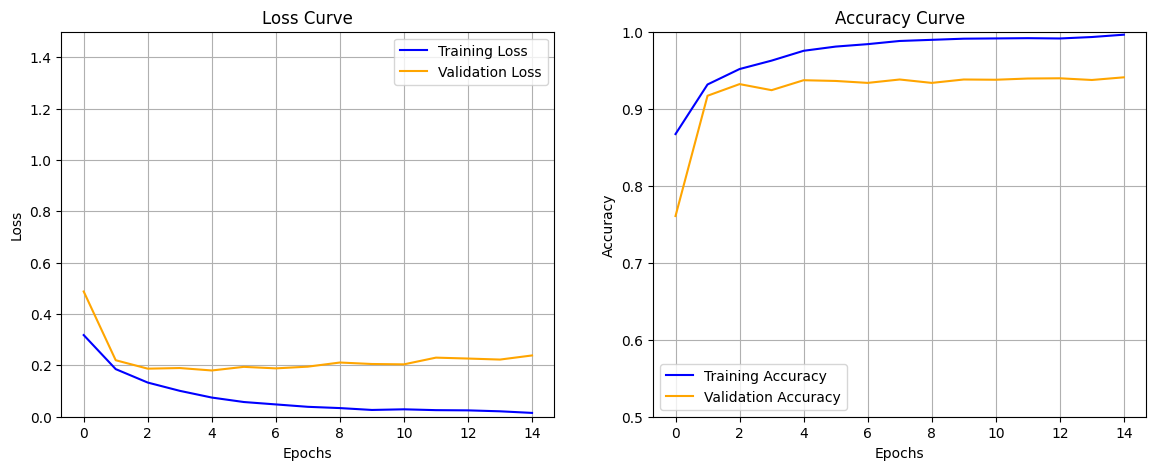

In [86]:
plot_training_history(history_bn)

In [87]:
bn_df = pd.DataFrame(history_bn.history)
bn_df.to_csv("bn_df.csv", index=False)

In [88]:
bn_model.save('bn_model_final.keras')

In [89]:
bn_model.save_weights('bn_model_final.weights.h5')

### L2 Regularisation Model

In [98]:
def create_l2_regularized_model_3(l2_lambda):
    base_model = EfficientNetB0(
        include_top=False, weights="imagenet", input_shape=(224, 224, 3)
    )
    base_model.trainable = True

    l2_reg = regularizers.l2(l2_lambda)  #the lambda (penalty) value

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),       
        layers.Dense(128, activation='relu', kernel_regularizer=l2_reg),  # L2 regularisation
        layers.Dense(1, activation='sigmoid')  
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.00005), 
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    return model

L2 penalty value grid search

In [ ]:
# l2_values = [1e-5, 1e-4, 1e-3, 1e-2]
# results = []

# for l2_val in l2_values:
#     print(f"Training with L2 lambda = {l2_val}")
#     model = create_l2_regularized_model_3(l2_val)
    
#     history = model.fit(
#         train_generator,
#         epochs=10,  
#         validation_data=val_generator,
#         callbacks=[
#             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#         ],
#         verbose=1
#     )
#     val_acc = history.history['val_accuracy'][-1]
#     results.append((l2_val, val_acc))

In [ ]:
# results.sort(key=lambda x: x[1], reverse=True)
# print("Best L2 lambda:", results[0][0])
# print("Best Validation Accuracy:", results[0][1])

Best L2 lambda: 0.01
Best Validation Accuracy: 0.9417322874069214

In [99]:
l2_model = create_l2_regularized_model_3(0.01)
l2_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 4,171,645 (15.91 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [100]:
history_l2 = l2_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15
)

Epoch 1/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 183s 214ms/step - accuracy: 0.8356 - loss: 2.4071 - val_accuracy: 0.8359 - val_loss: 1.6233
Epoch 2/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 63s 132ms/step - accuracy: 0.9364 - loss: 1.2335 - val_accuracy: 0.9310 - val_loss: 0.8225
Epoch 3/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 66s 142ms/step - accuracy: 0.9527 - loss: 0.6792 - val_accuracy: 0.9339 - val_loss: 0.5107
Epoch 4/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 63s 134ms/step - accuracy: 0.9656 - loss: 0.3797 - val_accuracy: 0.9443 - val_loss: 0.3373
Epoch 5/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 61s 131ms/step - accuracy: 0.9703 - loss: 0.2296 - val_accuracy: 0.9339 - val_loss: 0.2629
Epoch 6/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 72s 153ms/step - accuracy: 0.9809 - loss: 0.1346 - val_accuracy: 0.9471 - val_loss: 0.2266
Epoch 7/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 62s 132ms/step - accuracy: 0.9859 - loss: 0.0879 - val_accuracy: 0.9461 - val_loss: 0.2231
Epoch 8/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 67s 142ms/step - accuracy: 0.9872 - loss: 

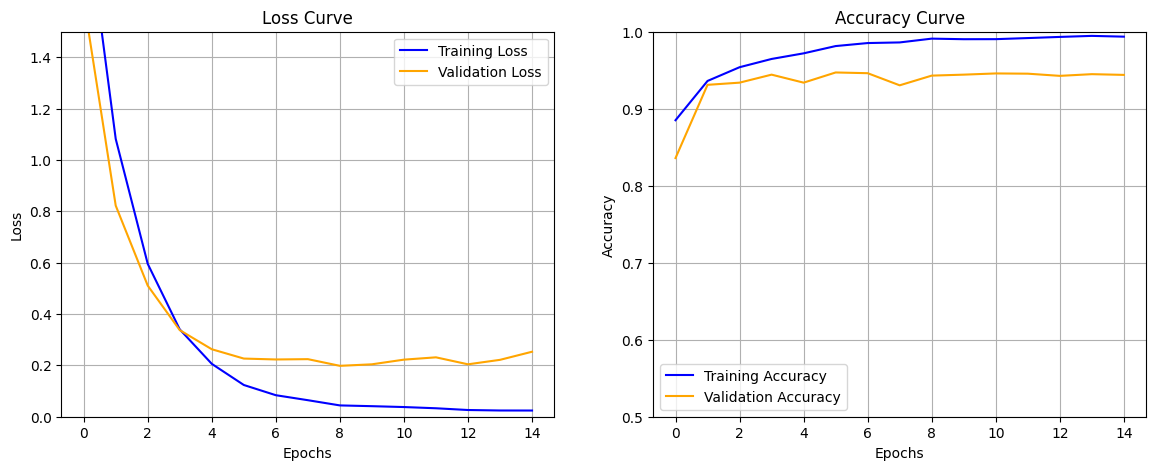

In [101]:
plot_training_history(history_l2)

In [102]:
L2_df = pd.DataFrame(history_l2.history)
L2_df.to_csv("L2_df.csv", index=False)

In [103]:
l2_model.save('l2_model_final.keras')

In [104]:
l2_model.save_weights('l2_model_final.weights.h5')

### Dropout Model

Manual random search for best dropout rates 

Two dropout layers:
- dropout_pooling_vals = [0.2, 0.3, 0.4]
- dropout_dense_vals = [0.3, 0.4, 0.5, 0.6]

In [ ]:
# dropout_pairs = [(0.2, 0.4), (0.4, 0.4), (0.3, 0.6)]
# dropout_pairs_2 = [(0.3, 0.3), (0.3, 0.5)]
# dropout_pairs_3 = [(0.4, 0.3), (0.3, 0.4), (0.4, 0.5)]
# dropout_pairs_4 = [(0.4, 0.6)]
# results = []

In [ ]:
# def plot_history(history, label):
#     plt.figure(figsize=(10, 4))

#     # Accuracy
#     plt.subplot(1, 2, 1)
#     plt.plot(history.history['accuracy'], label='Train')
#     plt.plot(history.history['val_accuracy'], label='Val')
#     plt.title(f'Accuracy ({label})')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     # Loss
#     plt.subplot(1, 2, 2)
#     plt.plot(history.history['loss'], label='Train')
#     plt.plot(history.history['val_loss'], label='Val')
#     plt.title(f'Loss ({label})')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()

#     plt.tight_layout()
#     plt.savefig(f'training_plot_dropout_{label}.png')
#     plt.close()

In [110]:
def create_dropout_model_3(dropout_pooling, dropout_dense):
    base_model = EfficientNetB0(
        include_top=False, weights="imagenet", input_shape=(224, 224, 3)
    )
    base_model.trainable = True
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),       
        layers.Dropout(dropout_pooling),          # Dropout after pooling layer
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_dense),            # Dropout after dense layer
        layers.Dense(1, activation='sigmoid')  
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.00005), 
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    return model

In [ ]:
# for d1, d2 in dropout_pairs_4:
#     label = f"{d1}_{d2}"
#     print(f"\n🔍 Training with dropout_pooling={d1}, dropout_dense={d2}")
#     model = create_dropout_model_3(dropout_pooling=d1, dropout_dense=d2)

#     history = model.fit(
#         train_generator,
#         validation_data=val_generator,
#         epochs=10,
#         callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
#         verbose=1
#     )

#     plot_history(history, label)

#     results.append({
#         'dropout_pooling': d1,
#         'dropout_dense': d2,
#         'final_val_accuracy': history.history['val_accuracy'][-1],
#         'final_val_loss': history.history['val_loss'][-1],
#         'best_val_accuracy': max(history.history['val_accuracy']),
#         'best_val_loss': min(history.history['val_loss']),
#         'epochs_run': len(history.history['loss'])
#     })

#     model.save(f"model_dropout_{label}.h5")

In [ ]:
# --- Export results ---
# df = pd.DataFrame(results)
# df.to_csv('dropout_search_results.csv', index=False)

# df_2 = pd.DataFrame(results)
# df_2.to_csv('dropout_search_results_2.csv', index=False)

# df_3 = pd.DataFrame(results)
# df_3.to_csv('dropout_search_results_3.csv', index=False)

# df_4 = pd.DataFrame(results)
# df_4.to_csv('dropout_search_results_4.csv', index=False)

# print(df_4)

best: dropout_pooling=0.3, dropout_dense=0.6 (alternative: 0.3, 0.5)

In [111]:
dropout_model = create_dropout_model_3(dropout_pooling=0.3, dropout_dense=0.6)
dropout_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 4,171,645 (15.91 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
# Define checkpoint callback to save the best model
# checkpoint_cb = ModelCheckpoint(
#     filepath='best_dropout_model.keras',
#     monitor='val_loss',
#     save_best_only=True,
#     save_weights_only=False,
#     mode='min',
#     verbose=1
# )

In [112]:
history_dropout = dropout_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15
)

Epoch 1/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 181s 210ms/step - accuracy: 0.7648 - loss: 0.4786 - val_accuracy: 0.7880 - val_loss: 0.4431
Epoch 2/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 63s 134ms/step - accuracy: 0.9237 - loss: 0.2026 - val_accuracy: 0.9291 - val_loss: 0.1840
Epoch 3/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 62s 133ms/step - accuracy: 0.9487 - loss: 0.1447 - val_accuracy: 0.9405 - val_loss: 0.1683
Epoch 4/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 61s 131ms/step - accuracy: 0.9588 - loss: 0.1141 - val_accuracy: 0.9335 - val_loss: 0.1894
Epoch 5/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 61s 131ms/step - accuracy: 0.9659 - loss: 0.0946 - val_accuracy: 0.9452 - val_loss: 0.1776
Epoch 6/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 61s 131ms/step - accuracy: 0.9757 - loss: 0.0680 - val_accuracy: 0.9417 - val_loss: 0.1867
Epoch 7/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 61s 131ms/step - accuracy: 0.9829 - loss: 0.0534 - val_accuracy: 0.9357 - val_loss: 0.1996
Epoch 8/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 61s 130ms/step - accuracy: 0.9876 - loss: 

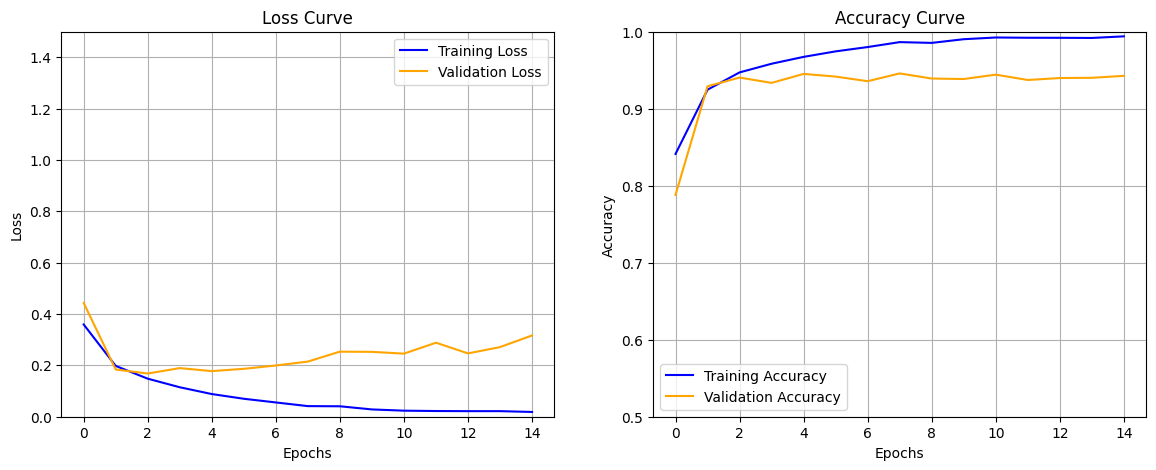

In [113]:
plot_training_history(history_dropout)

In [114]:
dropout_df = pd.DataFrame(history_dropout.history)
dropout_df.to_csv("dropout_df.csv", index=False)

In [115]:
dropout_model.save('dropout_model_final.keras')

In [116]:
dropout_model.save_weights('dropout_model_final.weights.h5')

### Augmentation Model

Manual search for best augmentation parameters for chest X-ray images

Mild augmentation to preserve important features:
- Small Rotation (5 to 15): Small rotations help the model become invariant to slight misalignments during X-ray capture. Large rotations (>15°) should be avoided as they could make the image unrealistic. 
- Small Width and Height Shifts (0.01 to 0.1): Helps the model handle minor patient positioning differences. Should be limited to avoid shifting important structures out of the field of view.
- Zoom (0.05 to 0.1): Slight zooming helps the model learn variations in image scale. Excessive zooming could crop out important diagnostic details.
- Horizontal Flip (Not Recommended): Chest X-rays are not symmetrical, especially when diagnosing conditions like pneumonia, tuberculosis, or heart enlargement. Flipping may change the anatomical meaning, leading to misdiagnosis.
- Shear (Not Recommended): Shearing distorts the image, which is not realistic for medical scans.
This could alter the shape of organs, misleading the model.
- Brightness_range: [[0.9, 1.1], [0.85, 1.15]]
- Fill Mode (fill_mode='nearest' OR 'constant')

1. default values (from previous model)  - the best for this model

In [122]:
augmented_data_gen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    fill_mode="nearest",
)

2. min values

In [ ]:
# augmented_data_gen = ImageDataGenerator(rotation_range=5,
#                                         width_shift_range=0.01,
#                                         height_shift_range=0.01,
#                                         zoom_range=0.05,
#                                         brightness_range=[0.9, 1.1],
#                                         fill_mode='nearest')

3 max values

In [ ]:
# augmented_data_gen = ImageDataGenerator(rotation_range=15,
#                                         width_shift_range=0.1,
#                                         height_shift_range=0.1,
#                                         zoom_range=0.1,
#                                         brightness_range=[0.85, 1.15],
#                                         fill_mode='nearest')

4. avg values

In [ ]:
# augmented_data_gen = ImageDataGenerator(rotation_range=10,
#                                         width_shift_range=0.05,
#                                         height_shift_range=0.05,
#                                         zoom_range=0.075,
#                                         brightness_range=[0.9, 1.1],
#                                         fill_mode='nearest')

5. variation of max values

In [ ]:
# augmented_data_gen = ImageDataGenerator(rotation_range=15,
#                                         width_shift_range=0.1,
#                                         height_shift_range=0.1,
#                                         zoom_range=0.1,
#                                         # fill_mode='nearest'
#                                         fill_mode='constant',
#                                         cval=0,
#                     )

In [123]:
train_augmented_generator = augmented_data_gen.flow_from_dataframe(
   dataframe=train_df,
    x_col='path',                    
    y_col="label",                   
    target_size=IMAGE_SIZE,          
    batch_size=BATCH_SIZE,
    class_mode="binary",             
    shuffle=True,
    seed=SEED_VALUE
)

Found 14815 validated image filenames belonging to 2 classes.


In [124]:
print_class_distribution(train_augmented_generator)

Class 'normal' (1): 7134 samples
Class 'abnormal' (0): 7681 samples


Batch shape: (32, 224, 224, 3)


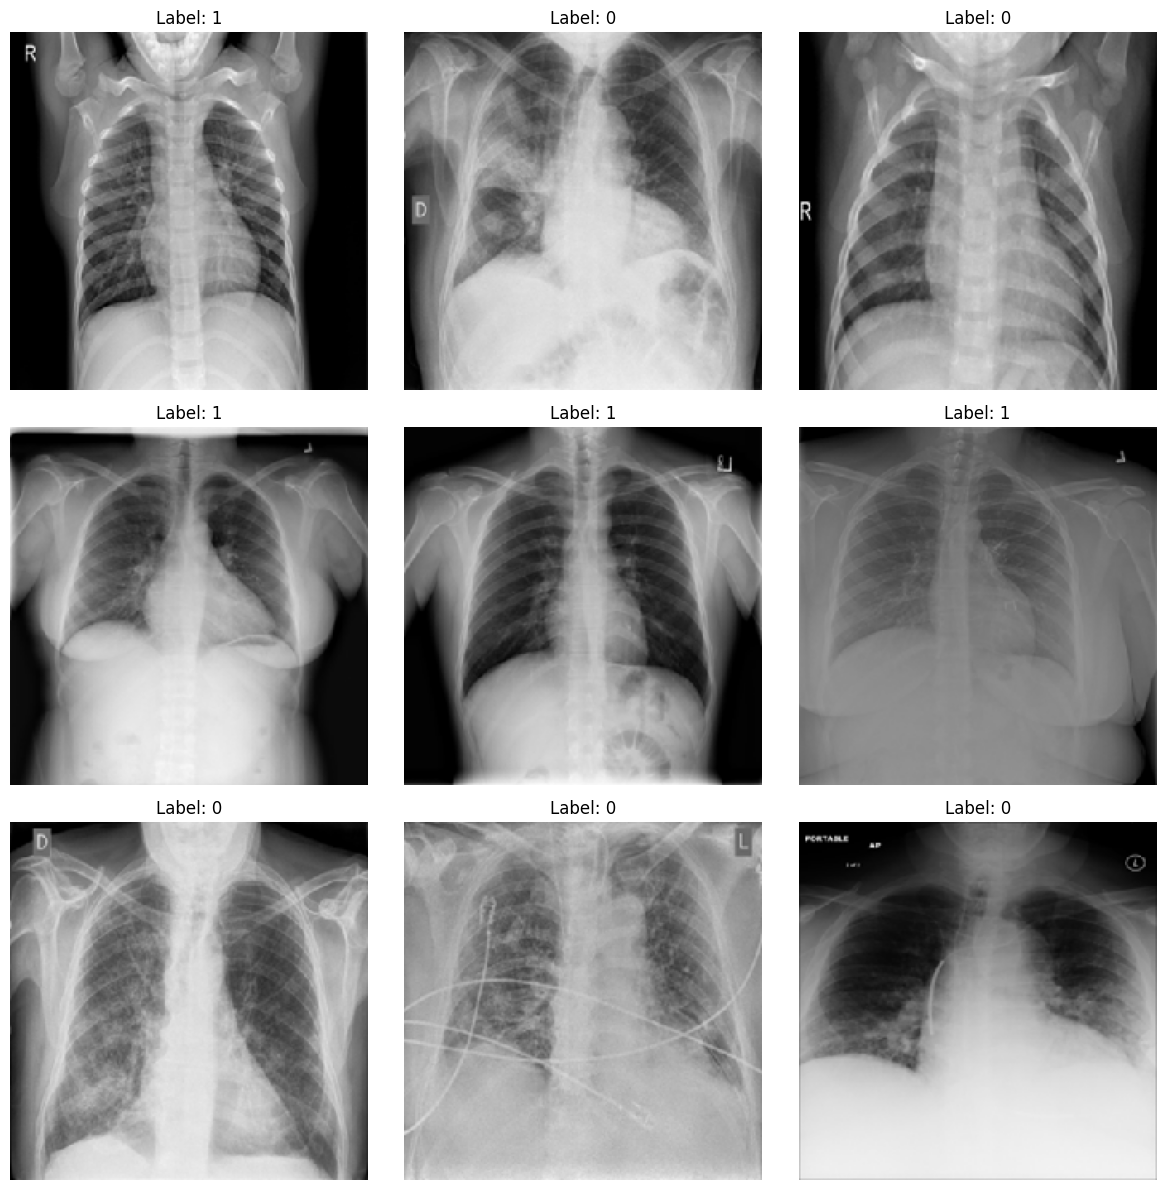

In [125]:
show_sample_images(test_generator)

In [126]:
augmented_model = create_baseline_model_3()
augmented_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 4,171,645 (15.91 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [127]:
history_augmented = augmented_model.fit(
    train_augmented_generator,
    validation_data=val_generator,
    epochs=15)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


463/463 ━━━━━━━━━━━━━━━━━━━━ 304s 478ms/step - accuracy: 0.8045 - loss: 0.4127 - val_accuracy: 0.8646 - val_loss: 0.3253
Epoch 2/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 200s 425ms/step - accuracy: 0.9238 - loss: 0.1941 - val_accuracy: 0.9093 - val_loss: 0.2251
Epoch 3/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 201s 428ms/step - accuracy: 0.9374 - loss: 0.1623 - val_accuracy: 0.9332 - val_loss: 0.1682
Epoch 4/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 195s 416ms/step - accuracy: 0.9477 - loss: 0.1331 - val_accuracy: 0.9298 - val_loss: 0.1748
Epoch 5/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 181s 386ms/step - accuracy: 0.9576 - loss: 0.1142 - val_accuracy: 0.8970 - val_loss: 0.2496
Epoch 6/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 192s 409ms/step - accuracy: 0.9600 - loss: 0.1024 - val_accuracy: 0.9373 - val_loss: 0.1609
Epoch 7/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 197s 420ms/step - accuracy: 0.9685 - loss: 0.0822 - val_accuracy: 0.9443 - val_loss: 0.1636
Epoch 8/15
463/463 ━━━━━━━━━━━━━━━━━━━━ 187s 398ms/step - accuracy: 0.9720 - loss: 0.08

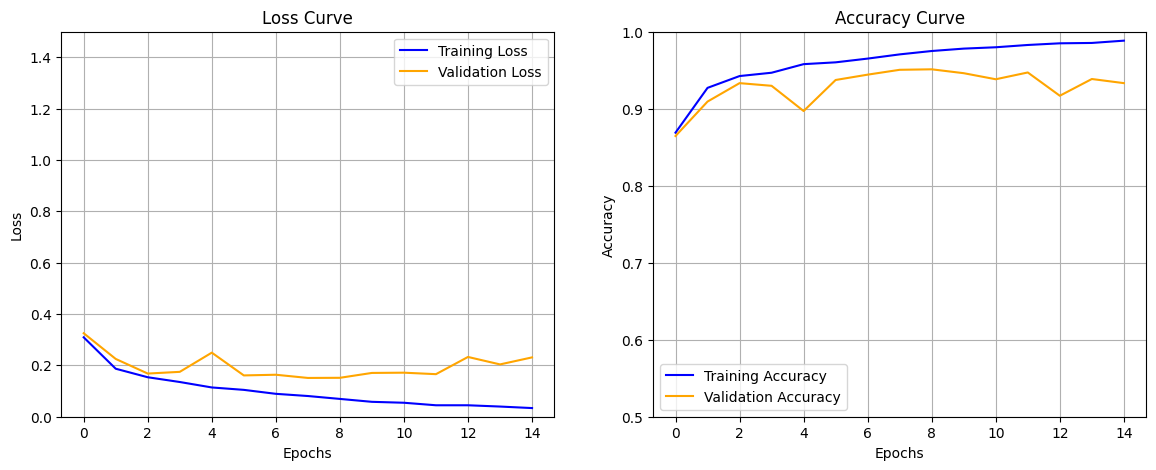

In [128]:
plot_training_history(history_augmented)

In [129]:
augmented_df = pd.DataFrame(history_augmented.history)
augmented_df.to_csv("augmented_df.csv", index=False)

In [130]:
augmented_model.save('augmented_model_final.keras')

In [131]:
augmented_model.save_weights('augmented_model_final.weights.h5')

### Combined model

In [141]:
def create_combined_model_5():
    base_model = EfficientNetB0(
        include_top=False, weights="imagenet", input_shape=(224, 224, 3)
    )
    base_model.trainable = True

    l2_reg = regularizers.l2(0.01)                # lambda (penalty) value

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),       
        layers.Dropout(0.3),                                               # Dropout after pooling
        
        layers.Dense(128, activation='relu', kernel_regularizer=l2_reg),   # L2 regularisation
        layers.BatchNormalization(),                                       # Batch normalisation
        layers.Dropout(0.6),                                               # Dropout after dense layer
        
        layers.Dense(1, activation='sigmoid')  
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.00005), 
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    return model

In [142]:
combined_model = create_combined_model_5()
combined_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_8           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,214,180 (16.08 MB)

 Trainable params: 4,171,901 (15.91 MB)

 Non-trainable params: 42,279 (165.16 KB)

In [143]:
history_combined_model = combined_model.fit(
    #train_augmented_generator,
    train_generator,
    validation_data=val_generator,
    epochs=25
)

Epoch 1/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 187s 215ms/step - accuracy: 0.7375 - loss: 2.8778 - val_accuracy: 0.8000 - val_loss: 2.4682
Epoch 2/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 69s 145ms/step - accuracy: 0.8837 - loss: 2.2657 - val_accuracy: 0.9225 - val_loss: 1.9715
Epoch 3/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 62s 133ms/step - accuracy: 0.9156 - loss: 1.9212 - val_accuracy: 0.9222 - val_loss: 1.7533
Epoch 4/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 63s 135ms/step - accuracy: 0.9329 - loss: 1.6500 - val_accuracy: 0.9206 - val_loss: 1.5391
Epoch 5/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 61s 130ms/step - accuracy: 0.9411 - loss: 1.4340 - val_accuracy: 0.9310 - val_loss: 1.3425
Epoch 6/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 62s 133ms/step - accuracy: 0.9536 - loss: 1.2208 - val_accuracy: 0.9128 - val_loss: 1.1979
Epoch 7/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 62s 131ms/step - accuracy: 0.9580 - loss: 1.0450 - val_accuracy: 0.9304 - val_loss: 1.0335
Epoch 8/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 65s 139ms/step - accuracy: 0.9675 - loss: 

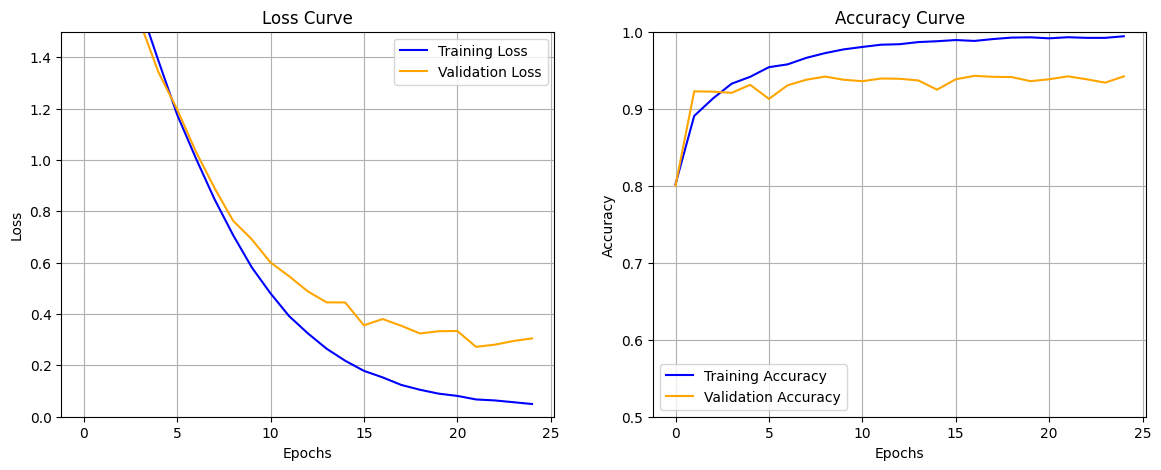

In [144]:
plot_training_history(history_combined_model)

In [145]:
combined_df = pd.DataFrame(history_combined_model.history)
combined_df.to_csv("combined_df.csv", index=False)

In [146]:
combined_model.save('combined_model_final.keras')

In [147]:
combined_model.save_weights('combined_model_final.weights.h5')

## Evaluate models

In [28]:
def evaluate_model(model, test_generator):
    predictions = model.predict(test_generator)
    y_pred = np.round(predictions).flatten()
    y_true = test_generator.classes
    
    accuracy = np.mean(y_pred == y_true)
    #accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, predictions)
    cm = confusion_matrix(y_true, y_pred)
    classification_rep = classification_report(y_true, y_pred)
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC Score: {auc:.4f}')
    print(f'Confusion Matrix:\n{cm}')
    print(f'Classification Report:\n{classification_rep}')

### Baseline Model

In [ ]:
# baseline_model = load_model('.keras')

In [72]:
print("Baseline Model:")
evaluate_model(baseline_model, test_generator)

Baseline Model:
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step
Accuracy: 0.9465
Precision: 0.9309
Recall: 0.9601
F1 Score: 0.9453
ROC AUC Score: 0.9839
Confusion Matrix:
[[1537  109]
 [  61 1468]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1646
           1       0.93      0.96      0.95      1529

    accuracy                           0.95      3175
   macro avg       0.95      0.95      0.95      3175
weighted avg       0.95      0.95      0.95      3175



In [90]:
y_pred_probs = baseline_model.predict(val_generator, verbose=1) # Step 1: Predict probabilities from the validation generator
y_true = val_generator.classes  # Step 2: Get the true labels from the generator
precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_probs) # Step 3: Calculate precision, recall, and F1 across thresholds
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8) # Step 4: Compute F1 scores

# Step 5: Find the best threshold
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F1 Score: {f1_scores[best_index]:.4f}")

# Step 6: Apply best threshold to get final predictions
y_pred = (y_pred_probs >= best_threshold).astype(int)

# Evaluate the performance with the new threshold
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))

100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step
Best Threshold: 0.1750
Best F1 Score: 0.9479
Confusion Matrix:
 [[1528  118]
 [  45 1484]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95      1646
           1       0.93      0.97      0.95      1529

    accuracy                           0.95      3175
   macro avg       0.95      0.95      0.95      3175
weighted avg       0.95      0.95      0.95      3175



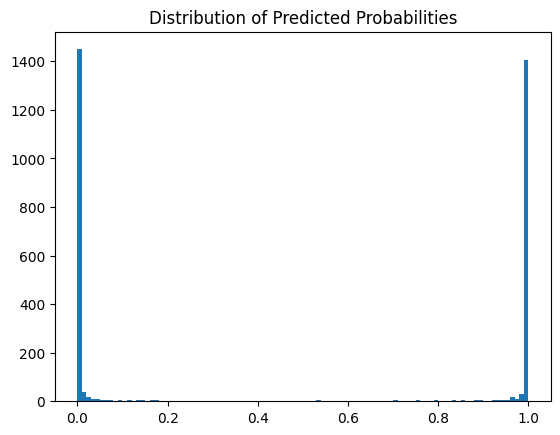

In [91]:
plt.hist(y_pred_probs, bins=100)
plt.title("Distribution of Predicted Probabilities")
plt.show()

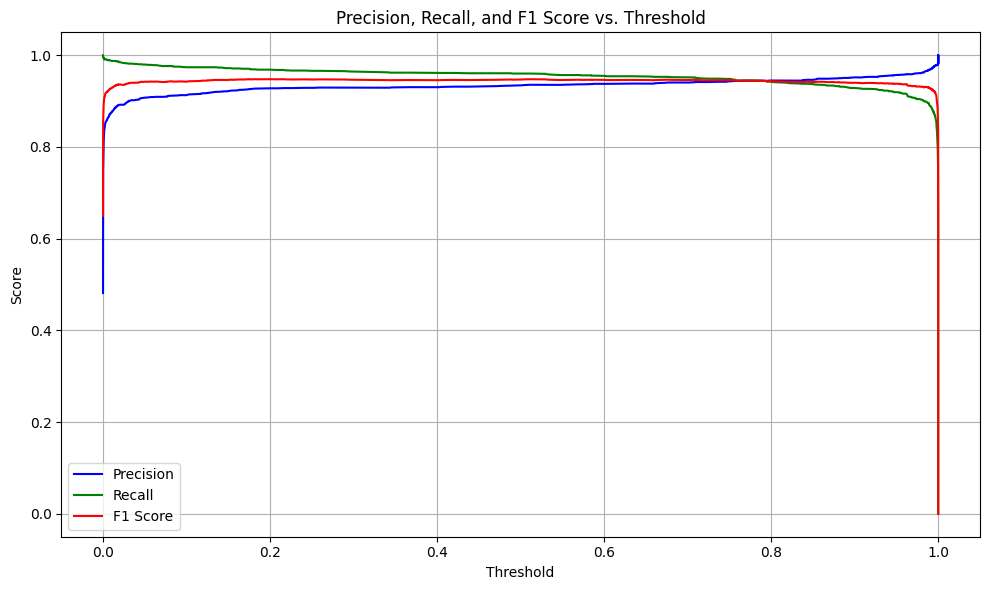

In [92]:
# thresholds has one less element than precisions/recalls — adjust for plotting
thresholds_extended = np.append(thresholds, 1.0)

plt.figure(figsize=(10, 6))
plt.plot(thresholds_extended, precisions, label='Precision', color='blue')
plt.plot(thresholds_extended, recalls, label='Recall', color='green')
plt.plot(thresholds_extended, f1_scores, label='F1 Score', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### BN Model

In [ ]:
# bn_model = load_model('_.keras')

In [93]:
print("BN Model:")
evaluate_model(bn_model, test_generator)

BN Model:
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 158ms/step
Accuracy: 0.9430
Precision: 0.9343
Recall: 0.9483
F1 Score: 0.9413
ROC AUC Score: 0.9827
Confusion Matrix:
[[1544  102]
 [  79 1450]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1646
           1       0.93      0.95      0.94      1529

    accuracy                           0.94      3175
   macro avg       0.94      0.94      0.94      3175
weighted avg       0.94      0.94      0.94      3175



In [95]:
y_pred_probs = bn_model.predict(val_generator, verbose=1) # Step 1: Predict probabilities from the validation generator
y_true = val_generator.classes  # Step 2: Get the true labels from the generator
precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_probs) # Step 3: Calculate precision, recall, and F1 across thresholds
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8) # Step 4: Compute F1 scores

# Step 5: Find the best threshold
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F1 Score: {f1_scores[best_index]:.4f}")

# Step 6: Apply best threshold to get final predictions
y_pred = (y_pred_probs >= best_threshold).astype(int)

# Evaluate the performance with the new threshold
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))

100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step
Best Threshold: 0.3940
Best F1 Score: 0.9397
Confusion Matrix:
 [[1532  114]
 [  73 1456]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      1646
           1       0.93      0.95      0.94      1529

    accuracy                           0.94      3175
   macro avg       0.94      0.94      0.94      3175
weighted avg       0.94      0.94      0.94      3175



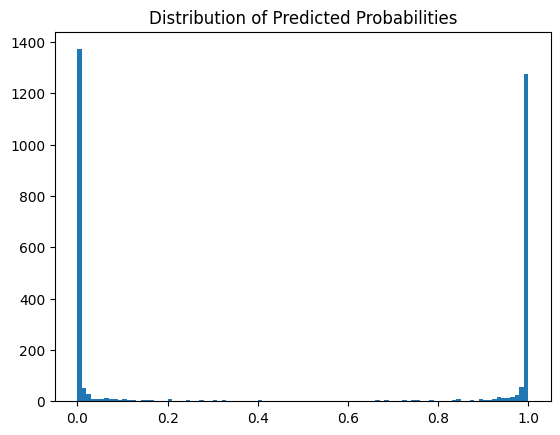

In [96]:
plt.hist(y_pred_probs, bins=100)
plt.title("Distribution of Predicted Probabilities")
plt.show()

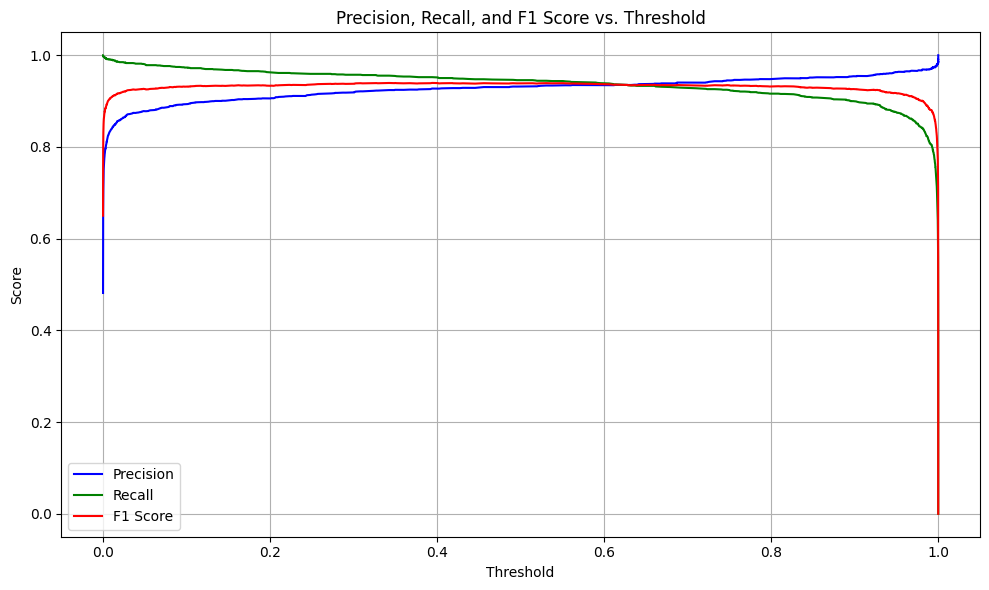

In [97]:
# thresholds has one less element than precisions/recalls — adjust for plotting
thresholds_extended = np.append(thresholds, 1.0)

plt.figure(figsize=(10, 6))
plt.plot(thresholds_extended, precisions, label='Precision', color='blue')
plt.plot(thresholds_extended, recalls, label='Recall', color='green')
plt.plot(thresholds_extended, f1_scores, label='F1 Score', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### L2 Model

In [ ]:
# l2_model = load_model('/kaggle/input/models-v2/models_v2/l2_model_10epochs (1).keras')

In [105]:
print("L2 Model:")
evaluate_model(l2_model, test_generator)

L2 Model:
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step
Accuracy: 0.9420
Precision: 0.9159
Recall: 0.9686
F1 Score: 0.9415
ROC AUC Score: 0.9847
Confusion Matrix:
[[1510  136]
 [  48 1481]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1646
           1       0.92      0.97      0.94      1529

    accuracy                           0.94      3175
   macro avg       0.94      0.94      0.94      3175
weighted avg       0.94      0.94      0.94      3175



In [106]:
y_pred_probs = l2_model.predict(val_generator, verbose=1) # Step 1: Predict probabilities from the validation generator
y_true = val_generator.classes  # Step 2: Get the true labels from the generator
precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_probs) # Step 3: Calculate precision, recall, and F1 across thresholds
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8) # Step 4: Compute F1 scores

# Step 5: Find the best threshold
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F1 Score: {f1_scores[best_index]:.4f}")

# Step 6: Apply best threshold to get final predictions
y_pred = (y_pred_probs >= best_threshold).astype(int)

# Evaluate the performance with the new threshold
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))

100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step
Best Threshold: 0.4972
Best F1 Score: 0.9436
Confusion Matrix:
 [[1518  128]
 [  49 1480]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.92      0.94      1646
           1       0.92      0.97      0.94      1529

    accuracy                           0.94      3175
   macro avg       0.94      0.95      0.94      3175
weighted avg       0.95      0.94      0.94      3175



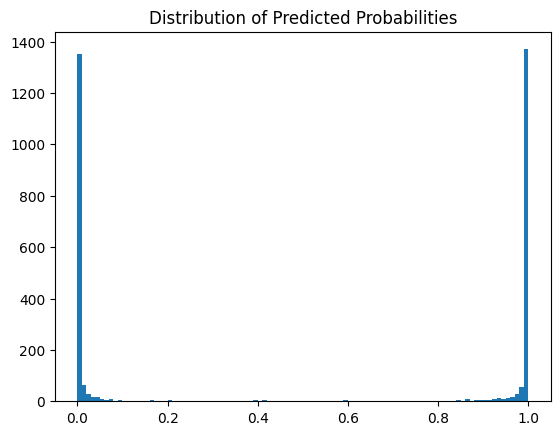

In [107]:
plt.hist(y_pred_probs, bins=100)
plt.title("Distribution of Predicted Probabilities")
plt.show()

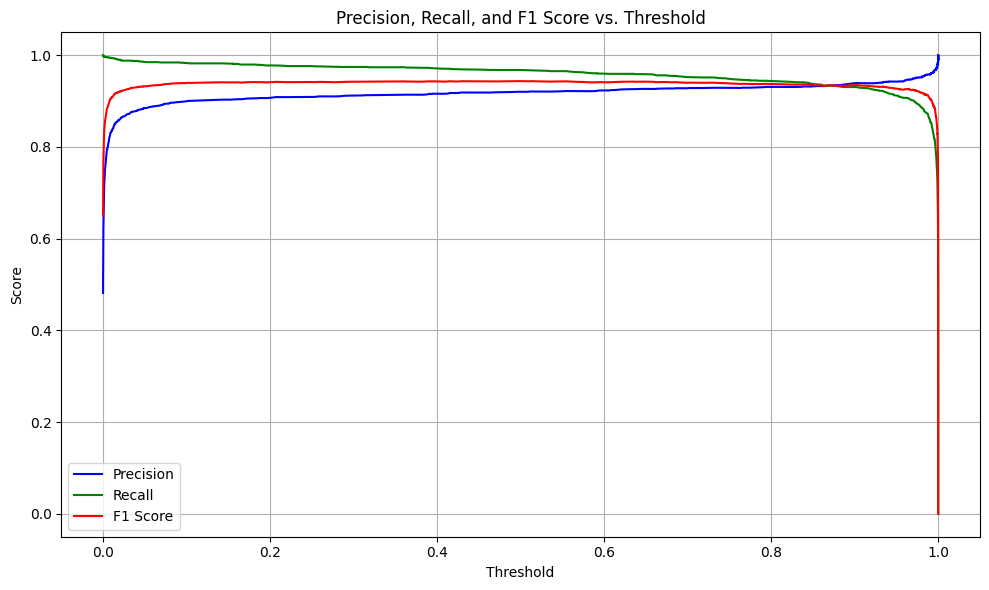

In [108]:
# thresholds has one less element than precisions/recalls — adjust for plotting
thresholds_extended = np.append(thresholds, 1.0)

plt.figure(figsize=(10, 6))
plt.plot(thresholds_extended, precisions, label='Precision', color='blue')
plt.plot(thresholds_extended, recalls, label='Recall', color='green')
plt.plot(thresholds_extended, f1_scores, label='F1 Score', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Dropout Model

In [ ]:
# dropout_model = load_model('/kaggle/input/models-v2/models_v2/dropout_model_10epochs (1).keras')

In [117]:
print("Dropout Model:")
evaluate_model(dropout_model, test_generator)

Dropout Model:
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 173ms/step
Accuracy: 0.9461
Precision: 0.9375
Recall: 0.9516
F1 Score: 0.9445
ROC AUC Score: 0.9856
Confusion Matrix:
[[1549   97]
 [  74 1455]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1646
           1       0.94      0.95      0.94      1529

    accuracy                           0.95      3175
   macro avg       0.95      0.95      0.95      3175
weighted avg       0.95      0.95      0.95      3175



In [118]:
y_pred_probs = dropout_model.predict(val_generator, verbose=1) # Step 1: Predict probabilities from the validation generator
y_true = val_generator.classes  # Step 2: Get the true labels from the generator
precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_probs) # Step 3: Calculate precision, recall, and F1 across thresholds
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8) # Step 4: Compute F1 scores

# Step 5: Find the best threshold
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F1 Score: {f1_scores[best_index]:.4f}")

# Step 6: Apply best threshold to get final predictions
y_pred = (y_pred_probs >= best_threshold).astype(int)

# Evaluate the performance with the new threshold
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step
Best Threshold: 0.0949
Best F1 Score: 0.9471
Confusion Matrix:
 [[1523  123]
 [  43 1486]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95      1646
           1       0.92      0.97      0.95      1529

    accuracy                           0.95      3175
   macro avg       0.95      0.95      0.95      3175
weighted avg       0.95      0.95      0.95      3175



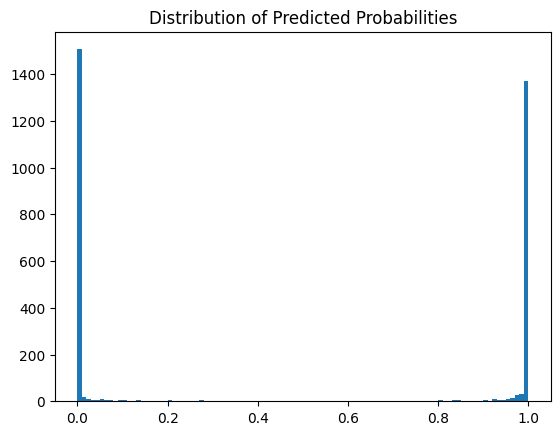

In [119]:
plt.hist(y_pred_probs, bins=100)
plt.title("Distribution of Predicted Probabilities")
plt.show()

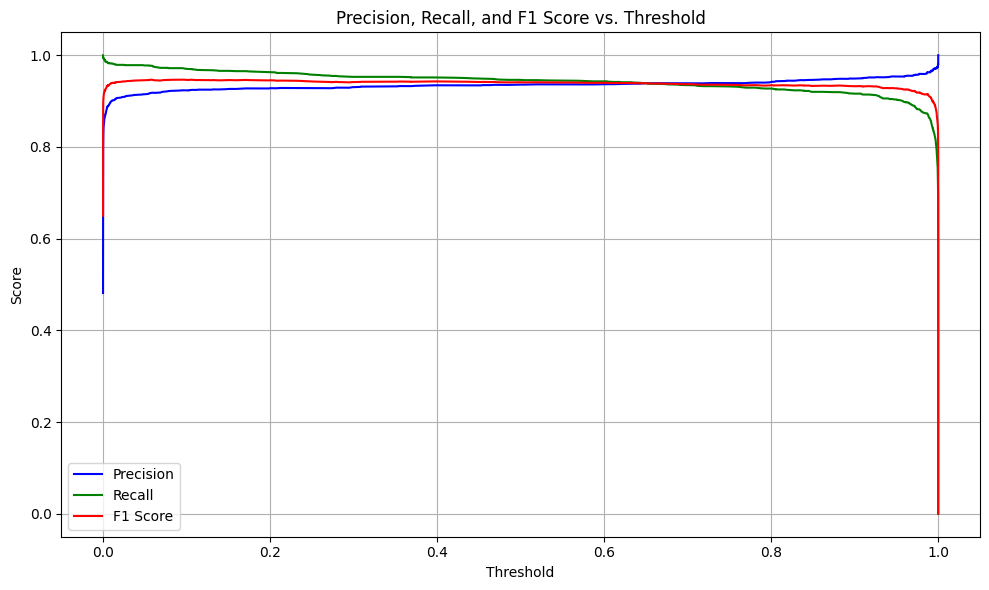

In [120]:
# thresholds has one less element than precisions/recalls — adjust for plotting
thresholds_extended = np.append(thresholds, 1.0)

plt.figure(figsize=(10, 6))
plt.plot(thresholds_extended, precisions, label='Precision', color='blue')
plt.plot(thresholds_extended, recalls, label='Recall', color='green')
plt.plot(thresholds_extended, f1_scores, label='F1 Score', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Augmented Model

In [132]:
print("Augmented Model:")
evaluate_model(augmented_model, test_generator)

Augmented Model:
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 188ms/step
Accuracy: 0.9310
Precision: 0.9450
Recall: 0.9097
F1 Score: 0.9270
ROC AUC Score: 0.9797
Confusion Matrix:
[[1565   81]
 [ 138 1391]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      1646
           1       0.94      0.91      0.93      1529

    accuracy                           0.93      3175
   macro avg       0.93      0.93      0.93      3175
weighted avg       0.93      0.93      0.93      3175



In [133]:
y_pred_probs = augmented_model.predict(val_generator, verbose=1) # Step 1: Predict probabilities from the validation generator
y_true = val_generator.classes  # Step 2: Get the true labels from the generator
precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_probs) # Step 3: Calculate precision, recall, and F1 across thresholds
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8) # Step 4: Compute F1 scores

# Step 5: Find the best threshold
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F1 Score: {f1_scores[best_index]:.4f}")

# Step 6: Apply best threshold to get final predictions
y_pred = (y_pred_probs >= best_threshold).astype(int)

# Evaluate the performance with the new threshold
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))

100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step
Best Threshold: 0.0666
Best F1 Score: 0.9423
Confusion Matrix:
 [[1508  138]
 [  44 1485]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.92      0.94      1646
           1       0.91      0.97      0.94      1529

    accuracy                           0.94      3175
   macro avg       0.94      0.94      0.94      3175
weighted avg       0.94      0.94      0.94      3175



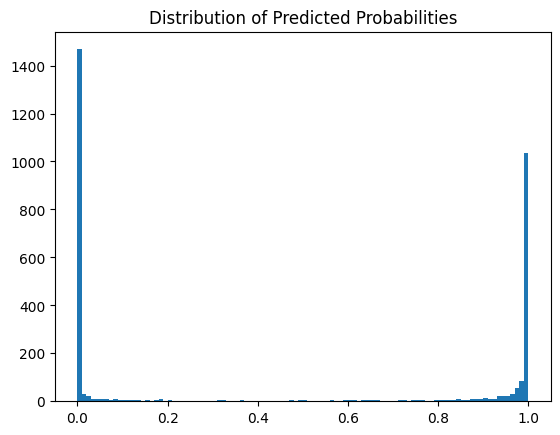

In [134]:
plt.hist(y_pred_probs, bins=100)
plt.title("Distribution of Predicted Probabilities")
plt.show()

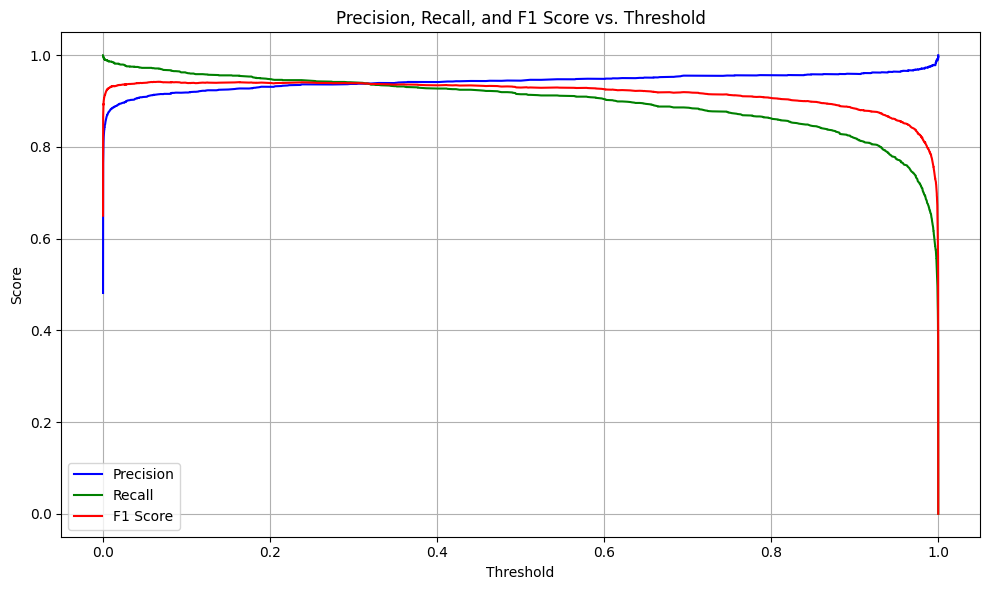

In [135]:
# thresholds has one less element than precisions/recalls — adjust for plotting
thresholds_extended = np.append(thresholds, 1.0)

plt.figure(figsize=(10, 6))
plt.plot(thresholds_extended, precisions, label='Precision', color='blue')
plt.plot(thresholds_extended, recalls, label='Recall', color='green')
plt.plot(thresholds_extended, f1_scores, label='F1 Score', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Combined model

In [148]:
# combined_model = load_model('best_combined_model.keras')
print("Combined Model:")
evaluate_model(combined_model, test_generator)

Combined Model:
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 181ms/step
Accuracy: 0.9433
Precision: 0.9288
Recall: 0.9555
F1 Score: 0.9420
ROC AUC Score: 0.9849
Confusion Matrix:
[[1534  112]
 [  68 1461]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1646
           1       0.93      0.96      0.94      1529

    accuracy                           0.94      3175
   macro avg       0.94      0.94      0.94      3175
weighted avg       0.94      0.94      0.94      3175



In [149]:
y_pred_probs = combined_model.predict(val_generator, verbose=1) # Step 1: Predict probabilities from the validation generator
y_true = val_generator.classes  # Step 2: Get the true labels from the generator
precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_probs) # Step 3: Calculate precision, recall, and F1 across thresholds
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8) # Step 4: Compute F1 scores

# Step 5: Find the best threshold
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F1 Score: {f1_scores[best_index]:.4f}")

# Step 6: Apply best threshold to get final predictions
y_pred = (y_pred_probs >= best_threshold).astype(int)

# Evaluate the performance with the new threshold
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))

100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step
Best Threshold: 0.6611
Best F1 Score: 0.9419
Confusion Matrix:
 [[1555   91]
 [  87 1442]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95      1646
           1       0.94      0.94      0.94      1529

    accuracy                           0.94      3175
   macro avg       0.94      0.94      0.94      3175
weighted avg       0.94      0.94      0.94      3175



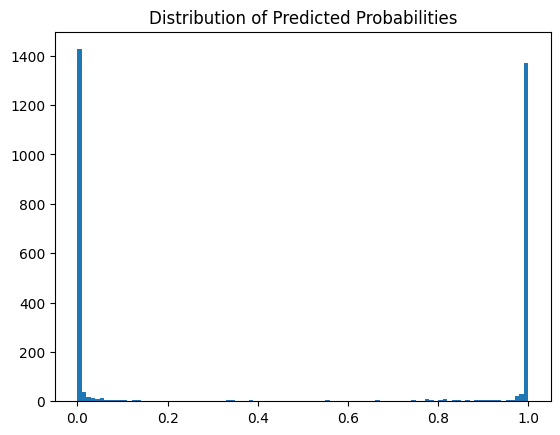

In [150]:
plt.hist(y_pred_probs, bins=100)
plt.title("Distribution of Predicted Probabilities")
plt.show()

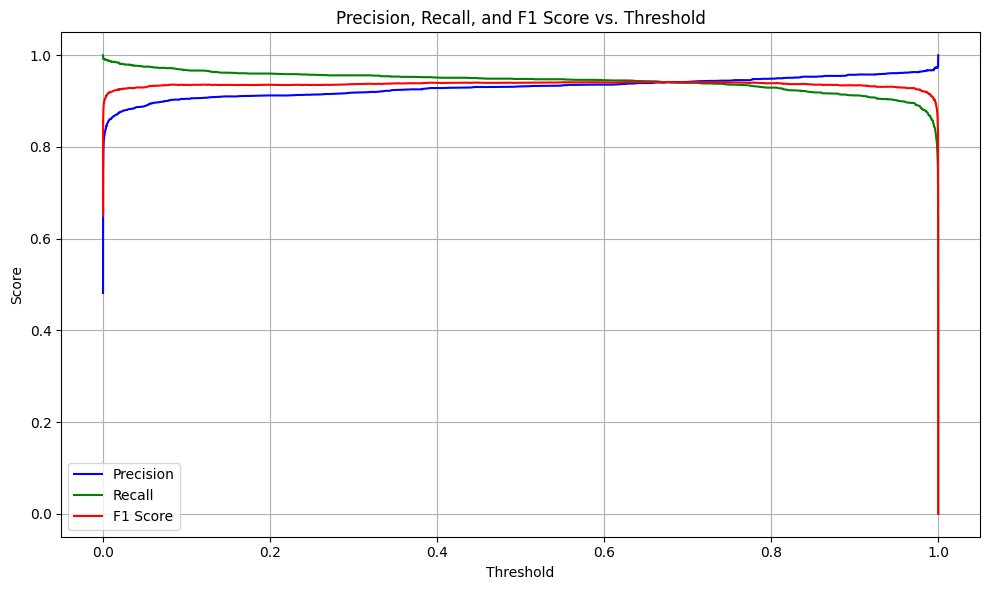

In [151]:
# thresholds has one less element than precisions/recalls — adjust for plotting
thresholds_extended = np.append(thresholds, 1.0)

plt.figure(figsize=(10, 6))
plt.plot(thresholds_extended, precisions, label='Precision', color='blue')
plt.plot(thresholds_extended, recalls, label='Recall', color='green')
plt.plot(thresholds_extended, f1_scores, label='F1 Score', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Test on External Data

In [43]:
all_xray_df = pd.read_csv(
    "../input/padchest-labels/PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv"
)
all_xray_df = all_xray_df[
    [
        "ImageID",
        "PatientID",
        "ViewPosition_DICOM",
        "Projection",
        "MethodProjection",
        "Pediatric",
        "Modality_DICOM",
        "MethodLabel",
        "Labels",
        "labelCUIS",
    ]
]
all_xray_df.head()

ImageID  \
0  20536686640136348236148679891455886468_k6ga29.png   
1  135803415504923515076821959678074435083_fzis7d...   
2  135803415504923515076821959678074435083_fzis7b...   
3  113855343774216031107737439268243531979_3k951l...   
4  113855343774216031107737439268243531979_3k951n...   

                                 PatientID ViewPosition_DICOM Projection  \
0     839860488694292331637988235681460987    POSTEROANTERIOR         PA   
1  313572750430997347502932654319389875966            LATERAL          L   
2  313572750430997347502932654319389875966    POSTEROANTERIOR         PA   
3   50783093527901818115346441867348318648    POSTEROANTERIOR         PA   
4   50783093527901818115346441867348318648            LATERAL          L   

                MethodProjection Pediatric Modality_DICOM MethodLabel  \
0  Manual review of DICOM fields        No             CR   Physician   
1  Manual review of DICOM fields        No             CR   Physician   
2  Manual review of DICOM fields        No             CR   Physician   
3  Manual review of DICOM fields        No             CR   Physician   
4  Manual review of DICOM fields        No             CR   Physician   

                                              Labels  \
0                                         ['normal']   
1  ['pulmonary fibrosis', 'chronic changes', 'kyp...   
2  ['pulmonary fibrosis', 'chronic changes', 'kyp...   
3                                ['chronic changes']   
4                                ['chronic changes']   

                                       labelCUIS  
0                                             []  
1  ['C0034069' 'C0742362' 'C2115817' 'C3544344']  
2  ['C0034069' 'C0742362' 'C2115817' 'C3544344']  
3                                   ['C0742362']  
4                                   ['C0742362']

In [44]:
xray_df = all_xray_df[all_xray_df['Projection'].isin(['AP','PA','AP_horizontal'])]

In [45]:
pneumonia_df = xray_df[
    (xray_df["Labels"].str.contains("pneumonia", na=False))
    | (xray_df["Labels"].str.contains("infiltr", na=False))
    | (xray_df["Labels"] == "['normal']")
]  # na=False if NaN, they will be treated as False rather than raising an error
pneumonia_df.shape

(44378, 10)

In [46]:
pneumonia_df["label"] = pneumonia_df["Labels"].apply(
    lambda x: "1" if x == "['normal']" else "0"
)
pneumonia_df.head()

/tmp/ipykernel_31/2651374384.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pneumonia_df["label"] = pneumonia_df["Labels"].apply(


ImageID  \
0   20536686640136348236148679891455886468_k6ga29.png   
10  313723174271082992847610802266403640553_w8dk8c...   
11  313723174271082992847610802266403640553_5_2icw...   
14  238285621348398466668514178112618553012_a7k6dv...   
15  152191969602076825998375638267191596461_ck9qkz...   

                                  PatientID ViewPosition_DICOM     Projection  \
0      839860488694292331637988235681460987    POSTEROANTERIOR             PA   
10   93535126770783451980359712286922420997                NaN  AP_horizontal   
11   93535126770783451980359712286922420997                NaN  AP_horizontal   
14   76478060312810134599679306720116852498                 PA             PA   
15  211676018114322936525876155155978326212    POSTEROANTERIOR             PA   

                 MethodProjection Pediatric Modality_DICOM MethodLabel  \
0   Manual review of DICOM fields        No             CR   Physician   
10  Manual review of DICOM fields        No             CR   Physician   
11  Manual review of DICOM fields        No             CR   Physician   
14  Manual review of DICOM fields        No             DX   Physician   
15  Manual review of DICOM fields        No             CR   Physician   

                                               Labels  \
0                                          ['normal']   
10  ['pleural effusion', 'infiltrates', 'endotrach...   
11  ['heart insufficiency', 'pleural effusion', 's...   
14                                         ['normal']   
15                                         ['normal']   

                                            labelCUIS label  
0                                                  []     1  
10      ['C2073625' 'C0277877' 'C0336630' 'C0185792']     0  
11  ['C0018801' 'C2073625' 'C0185792' 'C2073707' '...     0  
14                                                 []     1  
15                                                 []     1

In [47]:
pneumonia_pivot = pneumonia_df.pivot_table(
    index="MethodLabel", columns="label", values="ImageID", aggfunc="count"
)
pneumonia_pivot.loc["Total"] = pneumonia_pivot.sum(axis=0)
pneumonia_pivot

label           0      1
MethodLabel             
Physician    1754   8925
RNN_model    6708  26991
Total        8462  35916

In [48]:
pneumonia_df = pneumonia_df[
    (pneumonia_df["MethodLabel"] == "Physician") | (pneumonia_df["label"] == "0")
]
pneumonia_df.shape

(17387, 11)

In [49]:
pneumonia_df = pneumonia_df[(pneumonia_df['Pediatric']!='PED')]
pneumonia_df.shape

(17326, 11)

In [50]:
_, downsampled_df = train_test_split(
    pneumonia_df,
    test_size=5100,
    stratify=pneumonia_df["label"],
    random_state=SEED_VALUE,
)

In [51]:
downsampled_df.shape

(5100, 11)

In [52]:
downsampled_df["path"] = downsampled_df["ImageID"].apply(
    lambda x: f"../input/padchest-8bit-subset/PadChest_8bit_RGB_pneumonia/{x}"
)

In [53]:
downsampled_df.head()

ImageID  \
8713    204799444041729637468186547962149441017_y5keir...   
21793   262711106460554642521568570708494450008_az4hzf...   
118041  216840111366964012339356563862009071102622362_...   
24013   40289891931741994525766705414882565340_ofan5t.png   
20565   181076673775522103253268019559398633810_-rcbzr...   

                                      PatientID ViewPosition_DICOM Projection  \
8713    336831839460823619579170167471430357437    POSTEROANTERIOR         PA   
21793    40737545589981750582154516197115941395                NaN         PA   
118041  136966519362831178011949261004973409761                NaN         PA   
24013   135770655553971636185387376409321614673                 PA         PA   
20565    63105492073931036732644272229731769611                NaN         PA   

                     MethodProjection Pediatric Modality_DICOM MethodLabel  \
8713    Manual review of DICOM fields        No             CR   Physician   
21793   Manual review of DICOM fields        No             CR   Physician   
118041  Manual review of DICOM fields        No             CR   RNN_model   
24013   Manual review of DICOM fields        No             DX   Physician   
20565   Manual review of DICOM fields        No             CR   Physician   

                             Labels                labelCUIS label  \
8713                     ['normal']                       []     1   
21793                    ['normal']                       []     1   
118041  ['COPD signs', 'pneumonia']  ['C0024117' 'C0032285']     0   
24013                    ['normal']                       []     1   
20565                    ['normal']                       []     1   

                                                     path  
8713    ../input/padchest-8bit-subset/PadChest_8bit_RG...  
21793   ../input/padchest-8bit-subset/PadChest_8bit_RG...  
118041  ../input/padchest-8bit-subset/PadChest_8bit_RG...  
24013   ../input/padchest-8bit-subset/PadChest_8bit_RG...  
20565   ../input/padchest-8bit-subset/PadChest_8bit_RG...

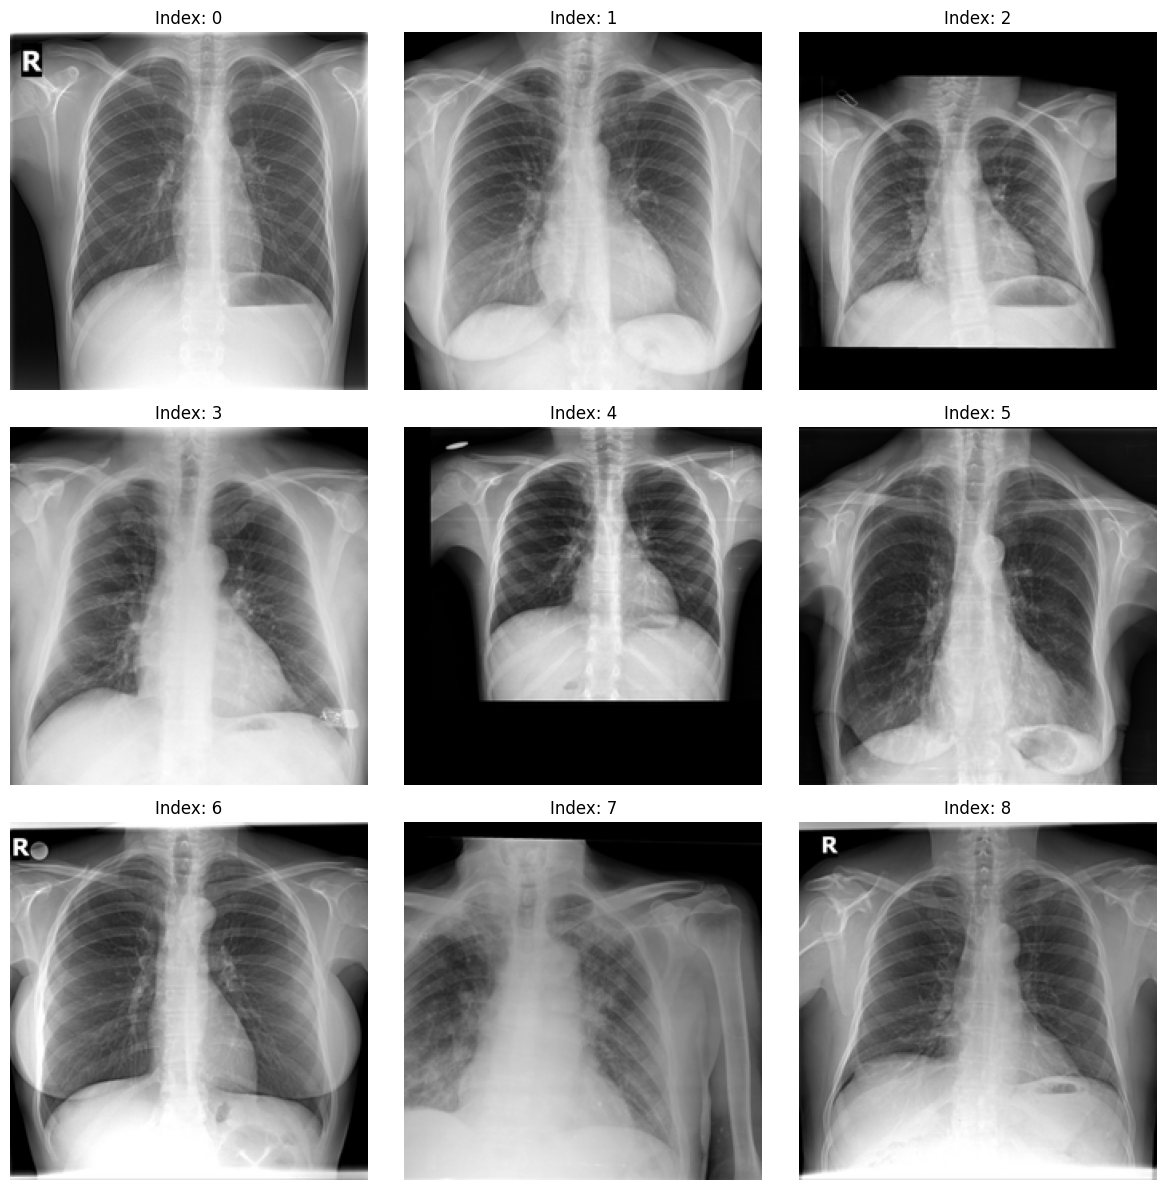

In [54]:
plt.figure(figsize=(12, 12))
for i in range(9):
    # Get image path from DataFrame
    img_path = downsampled_df['path'].iloc[i]
    
    # Open image
    img = Image.open(img_path)
    
    # Plot image
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Index: {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [55]:
ext_test_generator = data_gen.flow_from_dataframe(
   dataframe=downsampled_df,
   x_col="path",
   y_col="label",
   target_size=IMAGE_SIZE,
   batch_size=BATCH_SIZE,
   class_mode="binary",
   shuffle=False, # Do not shuffle test data to keep evaluation consistent
   seed=SEED_VALUE 
)

Found 5100 validated image filenames belonging to 2 classes.


In [56]:
print_class_distribution(ext_test_generator)

Class '1' (1): 2623 samples
Class '0' (0): 2477 samples


Batch shape: (32, 224, 224, 3)


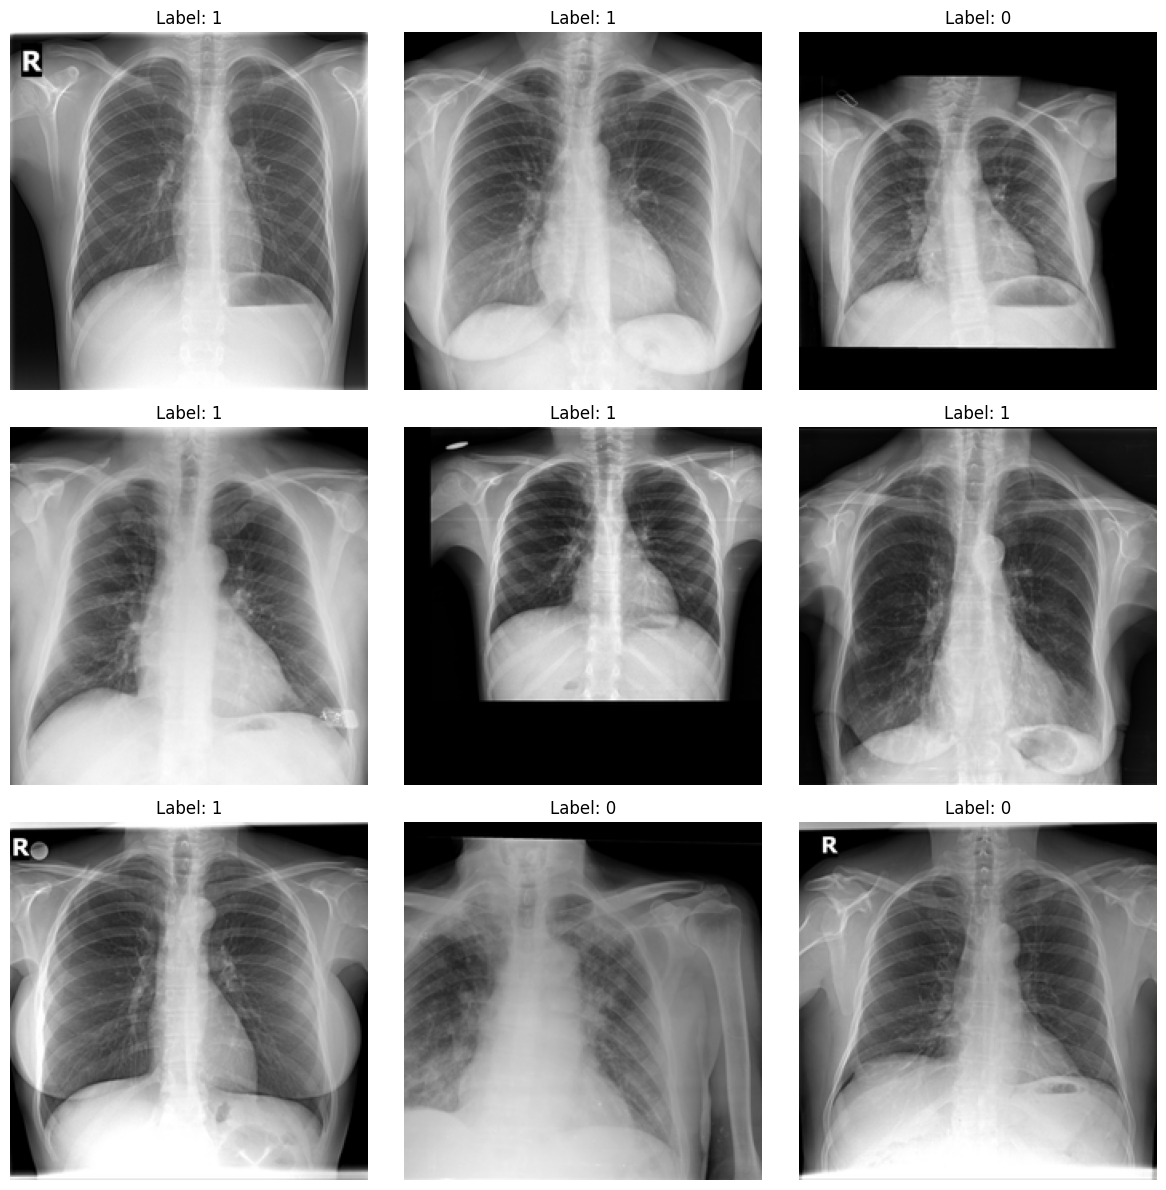

In [57]:
show_sample_images(ext_test_generator)

In [73]:
print("Baseline Model external:")
evaluate_model(baseline_model, ext_test_generator)

Baseline Model external:
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step
Accuracy: 0.7408
Precision: 0.7055
Recall: 0.8513
F1 Score: 0.7716
ROC AUC Score: 0.8024
Confusion Matrix:
[[1545  932]
 [ 390 2233]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.62      0.70      2477
           1       0.71      0.85      0.77      2623

    accuracy                           0.74      5100
   macro avg       0.75      0.74      0.74      5100
weighted avg       0.75      0.74      0.74      5100



In [94]:
print("BN Model external:")
evaluate_model(bn_model, ext_test_generator)

BN Model external:
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step
Accuracy: 0.7365
Precision: 0.7333
Recall: 0.7663
F1 Score: 0.7494
ROC AUC Score: 0.8071
Confusion Matrix:
[[1746  731]
 [ 613 2010]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.70      0.72      2477
           1       0.73      0.77      0.75      2623

    accuracy                           0.74      5100
   macro avg       0.74      0.74      0.74      5100
weighted avg       0.74      0.74      0.74      5100



In [109]:
print("L2 Model external:")
evaluate_model(l2_model, ext_test_generator)

L2 Model external:
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step
Accuracy: 0.7149
Precision: 0.7202
Recall: 0.7289
F1 Score: 0.7245
ROC AUC Score: 0.7883
Confusion Matrix:
[[1734  743]
 [ 711 1912]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.70      0.70      2477
           1       0.72      0.73      0.72      2623

    accuracy                           0.71      5100
   macro avg       0.71      0.71      0.71      5100
weighted avg       0.71      0.71      0.71      5100



In [121]:
print("Dropout Model external:")
evaluate_model(dropout_model, ext_test_generator)

Dropout Model external:
160/160 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step
Accuracy: 0.7673
Precision: 0.7359
Recall: 0.8540
F1 Score: 0.7905
ROC AUC Score: 0.8411
Confusion Matrix:
[[1673  804]
 [ 383 2240]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.68      0.74      2477
           1       0.74      0.85      0.79      2623

    accuracy                           0.77      5100
   macro avg       0.77      0.76      0.76      5100
weighted avg       0.77      0.77      0.77      5100



In [136]:
print("Augmented Model external:")
evaluate_model(augmented_model, ext_test_generator)

Augmented Model external:
160/160 ━━━━━━━━━━━━━━━━━━━━ 22s 137ms/step
Accuracy: 0.5496
Precision: 0.6332
Recall: 0.2955
F1 Score: 0.4029
ROC AUC Score: 0.6856
Confusion Matrix:
[[2028  449]
 [1848  775]]
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.82      0.64      2477
           1       0.63      0.30      0.40      2623

    accuracy                           0.55      5100
   macro avg       0.58      0.56      0.52      5100
weighted avg       0.58      0.55      0.52      5100



In [153]:
print("Combined Model external:")
evaluate_model(combined_model, ext_test_generator)

Combined Model external:
160/160 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step
Accuracy: 0.7790
Precision: 0.7401
Recall: 0.8791
F1 Score: 0.8036
ROC AUC Score: 0.8468
Confusion Matrix:
[[1667  810]
 [ 317 2306]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.67      0.75      2477
           1       0.74      0.88      0.80      2623

    accuracy                           0.78      5100
   macro avg       0.79      0.78      0.78      5100
weighted avg       0.79      0.78      0.78      5100

